# CHEST PAIN/DISCOMFORT

# Read data from database and build a line chart

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MySQLdb
import pandas as pd
import itertools
import statsmodels.api as sm
from datetime import datetime
from calendar import monthrange
import math
import warnings
warnings.filterwarnings("ignore")
def getData(county):
    county = county
    conn = MySQLdb.connect(host="localhost", user="i501fa18_group7", passwd="rEm9z3dRGW11", db="i501fa18_group7")
    cursor = conn.cursor()
    if(county == 'all'):
        condition = 'SIT_PROVIDER_PRIM_IMPRESSION = \'Chest Pain/Discomfort\''
    else:
        condition = 'inc_county = \'%s\' and SIT_PROVIDER_PRIM_IMPRESSION = \'Chest Pain/Discomfort\' ' % (county)

    str1="select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH , count(INC_INCIDENTID) as Numn_of_chest_calls from i501fa18_group7.emergency_medical_service_runs_2014 Where %s group by LAST_DAY(INC_INCIDENTDATE)"
    str2="union select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH , count(INC_INCIDENTID) as Numn_of_chest_calls from i501fa18_group7.emergency_medical_service_runs_2015 Where %s group by LAST_DAY(INC_INCIDENTDATE)"
    str3="union select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH , count(INC_INCIDENTID) as Numn_of_chest_calls from i501fa18_group7.emergency_medical_service_runs_2016 Where %s group by LAST_DAY(INC_INCIDENTDATE)"
    str4="union select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH, count(INC_INCIDENTID) as Numn_of_chest_calls from i501fa18_group7.emergency_medical_service_runs_2017 Where %s and LAST_DAY(INC_INCIDENTDATE) < \'2017-08-31\' group by LAST_DAY(INC_INCIDENTDATE)"

    query = str1%(condition) + str2%(condition)+ str3%(condition)+ str4%(condition)
    cursor.execute(query);
    rows = cursor.fetchall() 
    months = []
    chest_calls = []
    for i in rows:
        months.append(datetime.combine(i[0],datetime.min.time()))
        chest_calls.append(i[1])
    my_data = pd.DataFrame(
          {'Months': months,
           'Chest_Calls': chest_calls
          })
    
    my_data = my_data.set_index('Months')
    return my_data
def decomposeData(my_data):
    check_seasonal = sm.tsa.seasonal_decompose(my_data, model='multiplicative')
    fig = check_seasonal.plot()
    plt.title('Seasonal trending of the Chest Pain/Discomfort Calls Data')
    plt.show()
    
chest_pain_calls = getData('all'); 
print("Properties of the data are :" , chest_pain_calls.describe())
chest_pain_calls.plot(figsize=(15,6))
plt.title('Chest Pain/Discomfort calls by month')
plt.show()

Properties of the data are :        Chest_Calls
count    43.000000
mean   4115.372093
std     507.748861
min    2729.000000
25%    3798.000000
50%    4199.000000
75%    4431.000000
max    5001.000000


<Figure size 1500x600 with 1 Axes>

# Seasonal decompose of the data

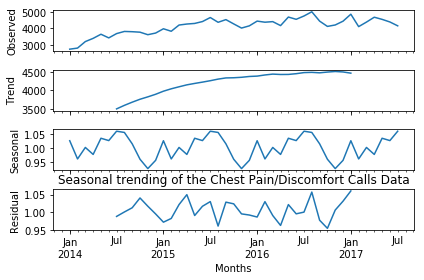

In [2]:
decomposeData(chest_pain_calls)

# Train the ARIMAX model for data from 2014 to 2017

In [3]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

min_aic = 1000
min_param = ()
min_param_seasonal = ()

train_data = chest_pain_calls[:2016]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            train_mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = train_mod.fit()
            if (results.aic <= min_aic):
                min_aic = results.aic
                min_param = param
                min_param_seasonal = param_seasonal
            
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

print('minimum AIC in observed at ', min_param, min_param_seasonal, min_aic)          

minimum AIC in observed at  (1, 1, 0) (1, 1, 0, 12) 247.83460810339776


# Build ARIMAX model using the parameters for minimum AIC

In [4]:
mod = sm.tsa.statespace.SARIMAX(chest_pain_calls, 
                                order= min_param,
                                seasonal_order= min_param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

for i in range(3):
    print(results.summary().tables[i])

                                 Statespace Model Results                                 
Dep. Variable:                        Chest_Calls   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -120.917
Date:                            Sat, 15 Dec 2018   AIC                            247.835
Time:                                    20:04:37   BIC                            250.334
Sample:                                01-31-2014   HQIC                           248.083
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3667      0.280      1.309      0.190      -0.182       0.916
ar.S.L12      -1.3723      0.366   

# Check diagnostics to make sure the model doesn't produce incorrect results

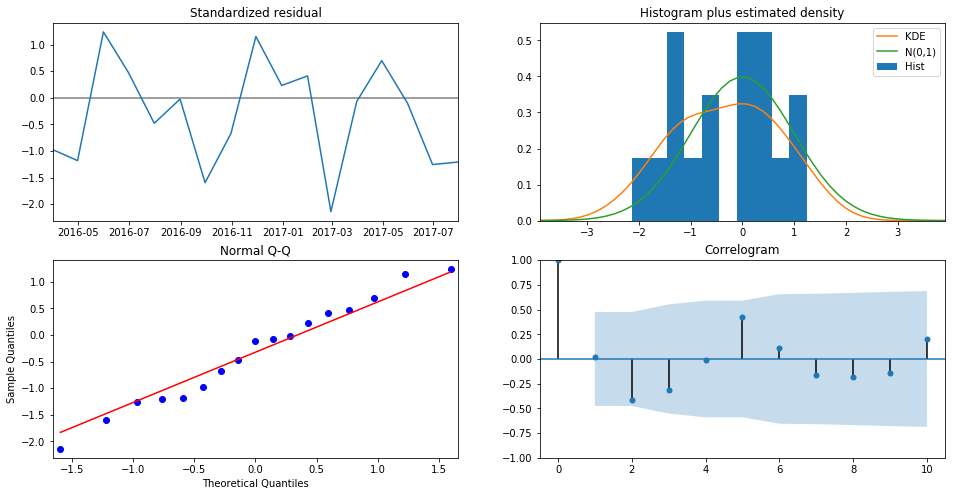

In [5]:
results.plot_diagnostics(figsize=(16,8))
plt.show()


# Predicting the values for 2017 based on training data...

                                 Statespace Model Results                                 
Dep. Variable:                        Chest_Calls   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -120.917
Date:                            Sat, 15 Dec 2018   AIC                            247.835
Time:                                    20:04:41   BIC                            250.334
Sample:                                01-31-2014   HQIC                           248.083
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3667      0.280      1.309      0.190      -0.182       0.916
ar.S.L12      -1.3723      0.366   

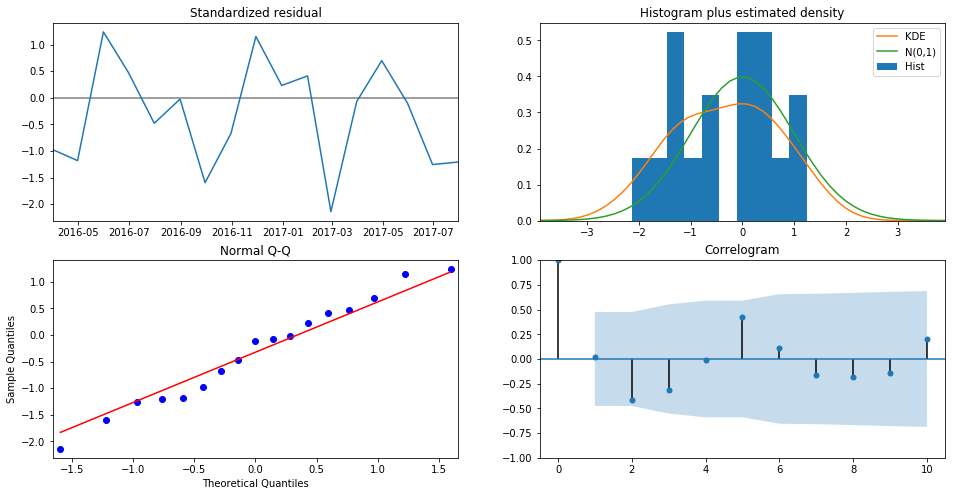

            lower Chest_Calls  upper Chest_Calls
2017-01-31        4148.857506        5313.203699
2017-02-28        4152.521599        5316.867793
2017-03-31        3812.853592        4977.199785
2017-04-30        3880.656381        5045.002574
2017-05-31        3988.950325        5153.296519
2017-06-30        4171.719117        5336.065310
2017-07-31        3923.568533        5087.914726


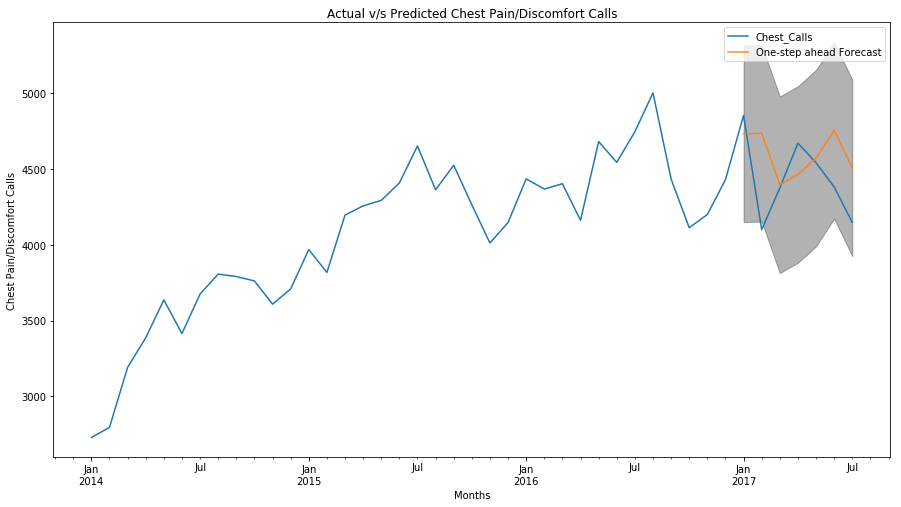

In [6]:
def forecastCHESTPAIN(in_data):
    mod = sm.tsa.statespace.SARIMAX(chest_pain_calls, 
                                order= min_param,
                                seasonal_order= min_param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()

    for i in range(3):
        print(results.summary().tables[i])
        
    results.plot_diagnostics(figsize=(16,8))
    plt.show()


    pred = results.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
    pred_ci = pred.conf_int() 
    ax = in_data['2014':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, figsize=(15, 8))
    print(pred_ci)
    ax.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.3)
    ax.set_xlabel('Months')
    ax.set_ylabel('Chest Pain/Discomfort Calls')
    plt.legend()
    plt.title('Actual v/s Predicted Chest Pain/Discomfort Calls')
    plt.show()
    
forecastCHESTPAIN(chest_pain_calls)